FCPG Tools (v2) Test Notebooks
===============================

In [ ]:
# import non-fcpgtools dependencies
import xarray as xr
import geopandas as gpd
import numpy as np
import pydaymet
from pathlib import Path
from importlib import reload

In [ ]:
# import fcpgtools using conda-develop
!conda-develop C:\\Users\\xrnogueira\\Documents\\FCPGtools\\src
import fcpgtools
reload(fcpgtools)
print(f'fcpgtools directory: {dir(fcpgtools)}')

path exists, skipping C:\Users\xrnogueira\Documents\FCPGtools\src
completed operation for: C:\Users\xrnogueira\Documents\FCPGtools\src
fcpgtools directory: ['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'terrainengine', 'tools', 'types', 'utilities']


In [ ]:
# get all necessary paths for in/out data
examples_dir = str(Path.cwd())
if 'FCPGtools' in examples_dir:
    examples_dir = Path(examples_dir.split('FCPGtools', 2)[0] + 'FCPGtools\\examples')
    print(f'var:examples_dir = {examples_dir}')
else:
    del examples_dir
    print('ERROR: Cant find /FCPGtools/examples!')

var:examples_dir = c:\Users\xrnogueira\Documents\FCPGtools\examples


In [ ]:
# get all necessary paths for in/out data
in_data_dir = examples_dir / Path('in_data')
print(f'Variable in_data_dir accesses {in_data_dir}')
out_data_dir = examples_dir / Path('out_data')
print(f'Variable in_data_dir accesses {out_data_dir}')

Variable in_data_dir accesses c:\Users\xrnogueira\Documents\FCPGtools\examples\in_data
Variable in_data_dir accesses c:\Users\xrnogueira\Documents\FCPGtools\examples\out_data


# Import Data
**Local files:**
* `us_fdr`: upstream basin Flow Direction Raster (ESRI format).
* `ds_fdr`: downstream basin Flow Direction Raster (ESRI format).
* `landcover`: 
* `basins_shp`:

**Remote files:**
* `daymet_single`:
* `daymet_multi`: a 2021 monthly averaged DAYMET precipitation raster via `pydaymet`.

## Pull in local test data

### Get local raster files as `xr.DataArray`s 
**Note:** While seemingly redundant, using `pathlib.Path` objects improves application security, especially if deployed on a remote server. This is because string paths are passed into TauDEM command line calls, which opens a vunerability to custom strings that could control a server remotely. Assuring that all inputs are valid paths (therefore not arbitrary malicious strings), protects against this.

In [ ]:
# get tif data paths
us_fdr_tif = in_data_dir / Path('validation_upstream_fdr.tif')
ds_fdr_tif = in_data_dir / Path('validation_downstream_fdr.tif')
landcover_tif = in_data_dir / Path('NALCMS_2015.tif')
daymet_tif = in_data_dir / Path('validation_daymet_an_P_2017.tif')

# get upstream basin shapefile path
us_basin_shp_path = in_data_dir / Path('upstream_wbd.shp')

In [ ]:
us_fdr = fcpgtools.utilities.intake_raster(us_fdr_tif)
ds_fdr = fcpgtools.utilities.intake_raster(ds_fdr_tif)
landcover = fcpgtools.utilities.intake_raster(landcover_tif)
daymet_single = fcpgtools.utilities.intake_raster(daymet_tif)

### Get the upstrean basin shapefile as a `geopandas.GeoDataFrame`

In [ ]:
us_basin_shp = gpd.read_file(us_basin_shp_path)
us_basin_shp

,OBJECTID,TNMID,MetaSource,SourceData,SourceOrig,SourceFeat,LoadDate,NonContrib,NonContr_1,AreaSqKm,...,GNIS_ID,Name,States,HUC12,HUType,HUMod,ToHUC,Shape_Leng,Shape_Area,geometry
0,2685,{AAAE4745-7F69-4249-9EE6-61A0FDD375D2},{2E2678AC-0C9D-49CB-806B-540A9302D247},None,None,None,2013-01-18,0.0,0.0,133.04,...,0,Honey Draw-Colorado River,AZ,140700061105,S,DM,150100010303,0.805006,0.013444,"POLYGON ((-111.45208 36.90750, -111.45209 36.9..."
1,2737,{6ECBF3AC-20C7-4EA3-AF3A-F8DB61EF2BBB},{AEC557FF-82D8-4F4D-BF0D-2BF431714390},None,None,None,2017-10-25,0.0,0.0,90.55,...,0,Johnson Point-Paria River,"AZ,UT",140700070706,S,NM,150100010303,0.612730,0.009157,"POLYGON ((-111.69386 37.00586, -111.69386 37.0..."


# Convert EDRI FDR to TauDEM FDR

In [ ]:
# display the dicts sotring D8 formats
print('D8 Formats supported by FCPGtools:')
display(fcpgtools.types.D8ConversionDicts)

D8 Formats supported by FCPGtools:


{'taudem': {'southeast': 8,
  'south': 7,
  'southwest': 6,
  'west': 5,
  'northwest': 4,
  'north': 3,
  'northeast': 2,
  'east': 1,
  'nodata': 0},
 'esri': {'southeast': 2,
  'south': 4,
  'southwest': 8,
  'west': 16,
  'northwest': 32,
  'north': 64,
  'northeast': 128,
  'east': 1,
  'nodata': 255}}

In [ ]:
%%time
# make a taudem FDR
us_fdr_taudem = fcpgtools.tools.convert_fdr_formats(
        us_fdr,
        out_format='taudem',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from esri format to taudem
CPU times: total: 422 ms
Wall time: 419 ms


TauDEM format ustream basin FDR


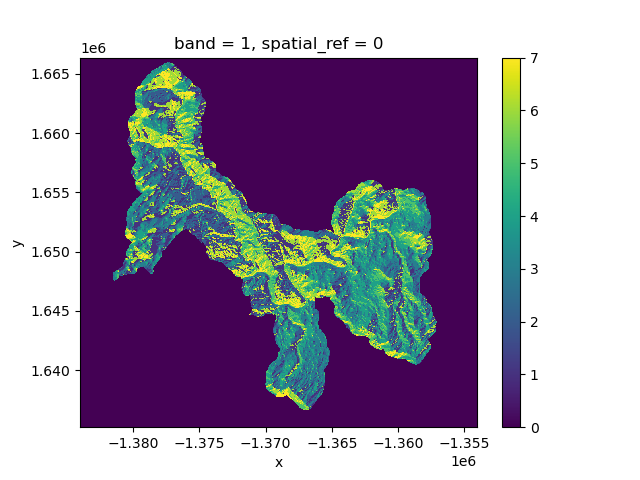

In [ ]:
%matplotlib widget
print('TauDEM format ustream basin FDR')
us_fdr_taudem.plot()

In [ ]:
%%time
# test back-conversion by re-making the esri format FDR
us_fdr_esri = fcpgtools.tools.convert_fdr_formats(
        us_fdr_taudem,
        out_format='esri',
        in_format=None,
        )

Converted the D8 Flow Direction Raster (FDR) from taudem format to esri
CPU times: total: 375 ms
Wall time: 395 ms


# Prep Parameter Grids

## Resample/reproject/clip Daymet and Land Cover

## Binarize Land Cover

# Accumulate the Upstream Area

# Demonstration of Multiple Pour Points

## Find Pout Point to Downstream Area

# Create Up- and Down-stream Daymet and Land Cover FCPGs

## FCPG Upstream Daymet and Land Cover

## Cascade to Downstream Area